In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
from skeleton import *
from sklearn.metrics import (recall_score, f1_score,
                             precision_score, accuracy_score)

# Clasificación

## Introducción

La tarea de clasificación es un tarea de aprendizaje supervisado, 
la cual consiste en predecir una variable categórica, esto a partir 
de un conjunto de elementos ya categorizados. Por ejemplo:

- Definir si un correo electrónico es o no spam
- Si un paciente padece o no cierta enfermedad
- Análisis de polaridad en mensajes de twitter
- Detección de humor, determinar si un texto es o no un chiste 
- Si un objeto aparece o no en una imagen 

Todos los ejemplos mencionados pueden plantearse como: generar 
un mapeo o etiquetado de un conjunto de datos $X$ (tweets, 
documentos, imágenes, registros medicos) con respecto a un conjunto 
de categorías ( positivo/negativo/neutro, enfermo/sano, 
aparece una persona/no aparece una persona). El caso particular en 
que solo existen dos categorías se denomina clasificación binaria.

Dado que la clasificación es una técnica supervisada es necesario 
contar con el conjunto de datos $X$ así como con su conjunto de etiquetas 
$y$.  Donde  $X=\{x_1,...,x_n\}$  y cada elemento $x_i$ está definido en  $\mathbb{R}^m$ y $y=\{\theta_1 ,...,\theta_n\}$ donde  $\theta_i$ es la etiqueta correspondiente a cada $x_i$  y se define en $\{1,...,k\}$ para $k$  diferentes 
categorías. 

El requerir las etiquetas del conjunto contrasta con el caso de clustering en el cual se intenta encontrar patrones que ayuden a describir el problema bajo estudio. Cómo puede suponerse el proceso de etiquetado generalmente lo hacen *"expertos"* en el dominio (medicos, psicólogos, lingüistas, personas, etc) y generalmente es un proceso costoso y que requiere mucho tiempo. 

Para comenzar vamos a inspeccionar un problema de clasificación binaria con dos dimensiones. Utilizaremos los datos sintéticos que nos proporciona la función ``make_blobs``.

In [2]:
from sklearn.datasets import make_blobs, make_circles,load_iris
blobs_X, blobs_y = make_blobs(centers=2, random_state=3)
print('X ~ n_sambles x n_features:', blobs_X.shape)
print('y ~ n_samples:', blobs_y.shape)
print('\n5 primeros ejemplos:\n', blobs_X[:5, :])
print('\n5 primeras etiquetas:', blobs_y[:5])

X ~ n_sambles x n_features: (100, 2)
y ~ n_samples: (100,)

5 primeros ejemplos:
 [[-3.75593847  0.06753833]
 [-2.94843418  0.3655385 ]
 [-3.36709068 -0.30343965]
 [ 1.89024377  2.86941982]
 [-4.77040684 -1.33000372]]

5 primeras etiquetas: [1 1 1 0 1]


Como los datos son en dos dimensiones, podemos representar cada punto en un sistema de coordenadas (ejes x e y).

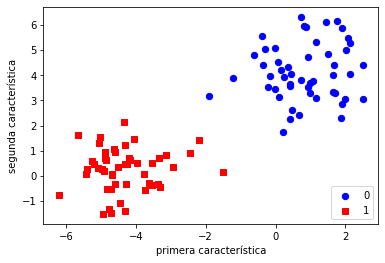

In [3]:
plt.scatter(blobs_X[blobs_y == 0, 0], blobs_X[blobs_y == 0, 1], 
            c='blue', s=40, label='0')
plt.scatter(blobs_X[blobs_y == 1, 0], blobs_X[blobs_y == 1, 1], 
            c='red', s=40, label='1', marker='s')

plt.xlabel('primera característica')
plt.ylabel('segunda característica')
plt.legend(loc='lower right');

Como ya mencionamos la clasificación es una tarea supervisada y, ya que estamos interesados en su rendimiento en datos no utilizados para entrenar, vamos a dividir los datos en dos partes:

1. un conjunto de entrenamiento que el algoritmo de aprendizaje utiliza para ajustar los parámetros del modelo
2. un conjunto de test para evaluar la capacidad de generalización del modelo (como se comportaba con datos nuevos, previamente no tratados, lo que podemos denominar una *prueba de realidad*).

||
|:---:|
|**División en entrenamiento  y  prueba**|

La función ``train_test_split`` del paquete ``model_selection`` hace justo esto por nosotros - la usaremos para generar una partición con un 70%//30% en entrenamiento y test, respectivamente.

In [4]:
from sklearn.model_selection import train_test_split
blobs_X_train,blobs_X_test,blobs_y_train,blobs_y_test = train_test_split(blobs_X, blobs_y,
                                                    test_size=0.30,
                                                    random_state=3,
                                                    stratify=blobs_y)

## Nearest Centroid Classifier

Nearest Centroid (NC)  es un clasificador (también llamado Mean Difference Classifier) simple y poderoso. NC  es un claro ejemplo del  principio de suficiencia estadística, el cual nos dice que se pueden construir algoritmos a partir de resúmenes simples y significativos de los datos de entrenamiento. La forma más simple de resumir un conjunto de datos es mediate su media geométrica o centroide.  NC  como clasificador asigna a cada ejemplo desconocido la misma clase de su centroide más cercano.


Nearest Centroid en combinación con representaciones vectoriales ha sido ampliamente utilizado para la clasificación de documentos, cada centroide es visto como una sumarización de todos los documentos conocidos para una determinada clase. Dado el conjunto de vectores $X$ (generados mediante alguna técnica de vectorización) y etiquetas $y$ con valores  $C= \{1,...,𝑘\}$ para $k$ diferentes categorias (para el caso binario $C=\{0,1\}$). Para obterne un clasificador NC se deben generar un centroide por cada clase. 

Para continuar con la notación de clustering que utilizamos en la sección anterior tenemos que:  $G_i$ es el conjunto de documentos que perteneces a la iésima clase y $c_i$ el centroide del grupo $G_i$. Como ya vimos cada $c_i$ puede no ser siempre la media geométrica (recuerde podía ser la mediana o incluso un elemento del conjunto). En el caso de representaciones de texto existen muchas propuestas para el cálculo del *"centroide"* reportadas en la literatura. Algunas de las más básicas son:


- **Rocchio**, para este caso cada centroide $c_j$ es representado por la suma de todos los vectores de la clase $i$ menos la suma de aquellos vectores que no pertenecen a la clase $i$, se puede realizar un pesado mediante parámetros de control $\beta$ y $\gamma$ (usualmente $\beta=16$ y $\gamma=4$).

$$c_j= \beta \frac{1}{|G_j|} \sum_{x_i \in G_j} x_i- \gamma \frac{1}{|X|-|G_j|} \sum_{x_i \notin G_j} x_i$$

- El **promedio**, donde cada centroide es calculado cómo la media geométrica de cada grupo.

$$c_j=\frac{1}{|G_j|}\sum_{x_i \in G_j} x_i$$

- La **suma**, es similar al promedio solo sin dividir por la cardinalidad del grupo

$$c_j=\sum_{x_i \in G_j} x_i$$

- La **suma normalizada**, cada centroide $c_j$ es calculado como la suma de todos los vectores de la clase $j$ pero normalizados. 

$$c_j= \frac{1}{||\sum_{x_i \in G_j} x_i||}\sum_{x_i \in G_j} x_i$$

Como ya podrá haberse inferido las etapa de entrenamiento y el proceso de predicción de un clasificador NC es muy eficiente, ya que para aprender solo se debe calcular el centroide para cada clase y para la predicción sólo encontrar el centroide más similar para el ejemplo a predecir. Mientras que el entrenamiento es lineal(multiplicado por un factor del costo de la función de similitud), el proceso de predicción es constante ya que solo depende del número de clases y no del tamaño del conjunto de entrenamiento. 

### Nearest Centroid Average

Ilustraremos el comportamiento de NC utilizando la versión promedio y la similitud coseno. Se dejan como ejercicio al estudiante implementar las otras versiones. Ilustraremos el comportamiento de NC utilizando la versión promedio y la similitud coseno. Se dejan como ejercicio al estudiante implementar las otras versiones. Como ejemplo para probar la implementación de ejemplo consideremos el dataset generado con **make_blobs**. 

Explícitamente el proceso de entrenamiento y predicción de NC utilizando como centroide el promedio se puede resumir como sigue:

------
**Nearest Centroid**
1. Etapa de entrenamiento
    - Para cada $j \in C$ 
        - $ \frac{1}{|G_j|}\sum_{\{x_i \in G_j\}} x_i$
2. Etapa de predicción
    - dado un ejemplo $x_q$ no etiquetado y una función de  similitud/distancia $d$ 
        - Para cada $c_j$
            - calcular $d(c_j,x_q)$
        - asignar $x_q$ con la misma clase que el $c_j$ más similar
------
------

donde $d$ se reemplaza con la función de distancia o similitud a utilizar.

Como parte del template python se proporciona el método Nearest Centroid con la variante promedio. Para probar la implementación de ejemplo consideremos el dataset generado con **make_blobs**. 

In [5]:
# Creamos y entrenamos una instancia del clasificador, utilizaremos la partición 
# de entrenamiento X_train, y_train
blobs_clf=NearestCentroid(distance='euclidiana',centroid_type="Average").fit(blobs_X_train,blobs_y_train)

In [6]:
# Tenemos un conjunto de centroides por clase (2 para ejemplo)
blobs_clf.centroids_

{0: array([0.8955109 , 4.34454257]), 1: array([-4.29739688,  0.25406326])}

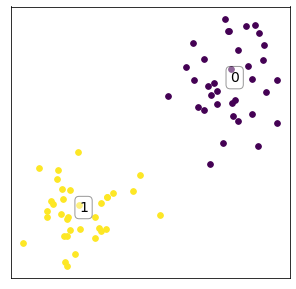

In [7]:
# Reutilizamos plotClusters para ver los centroides
plotClusters(blobs_X_train,blobs_y_train,blobs_clf.centroids_)

In [8]:
# Podemos predeccir las etiquetas del conjunto de prueba
blobs_yp=blobs_clf.predict(blobs_X_test)

In [9]:
blobs_yp

array([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1])

In [10]:
# Como es un ejemplo de juguete todo perfecto!
print("Etiquetas predecidad:", blobs_yp)
print("Etiquetas verdaderas:", blobs_y_test)

Etiquetas predecidad: [0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1]
Etiquetas verdaderas: [0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 1]


In [11]:
# Podemos utilizar las métricas de precision, recall y accuracy
print("Recall: ", recall_score(blobs_y_test,blobs_yp))
print("F1: ", f1_score(blobs_y_test,blobs_yp))
print("Precision: ", precision_score(blobs_y_test,blobs_yp))

Recall:  1.0
F1:  1.0
Precision:  1.0


Probemos con un ejemplo un poco diferente

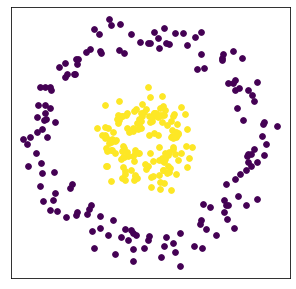

In [12]:
#Generamos los datos
circles_X,circles_y= make_circles(n_samples=300, noise=0.1, random_state=2, factor=0.3)
plotClusters(circles_X,circles_y)

In [13]:
#Particionamos en train y test
circles_X_train,circles_X_test, circles_y_train, circles_y_test = train_test_split(circles_X, circles_y,
                                                    test_size=0.30,
                                                    random_state=3,
                                                    stratify=circles_y)

In [14]:
# Instanciamos y entremamos un clasificacor nearest centroids
circles_clf=NearestCentroid().fit(circles_X_train,circles_y_train)

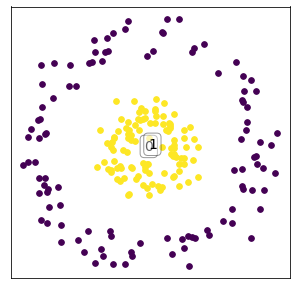

In [15]:
# Graficamos con los centroides
plotPCA(circles_X_train,circles_y_train,centroids=circles_clf.centroids_,vectors=False)

In [16]:
#Veamos que tan bien lo hace nearest centroid
circles_yp=circles_clf.predict(circles_X_test)
print("Recall: ", recall_score(circles_y_test,circles_yp))
print("F1: ", f1_score(circles_y_test,circles_yp))
print("Precision: ", precision_score(circles_y_test,circles_yp))

Recall:  0.4888888888888889
F1:  0.4888888888888889
Precision:  0.4888888888888889


Los resultados son incluso peor que lanzar una moneada. Esto ocurre dado que NC es un método lineal de clasificación y el segundo caso es claramente un conjunto de datos no lineal. La frontera de clasificación en ambos casos es lineal. 

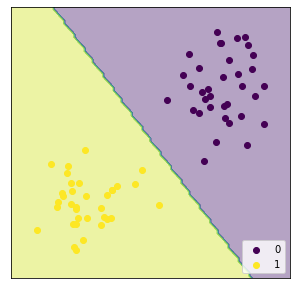

In [17]:
# Frontera para las blobs 
plotDecisionBoundary(blobs_clf,blobs_X_train,blobs_y_train)

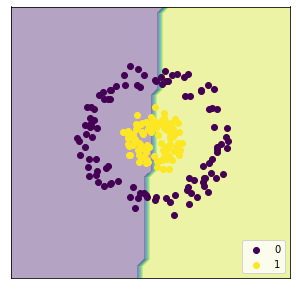

In [18]:
# Frontera para los circulos
plotDecisionBoundary(circles_clf,circles_X_train,circles_y_train)

Aún cuando en los casos no lineales, no funciona bien, la buena noticia es que para problemas de dimensiones grandes (como el caso de texto) los clasificadores lineales se desempeñan bien. Como último ejemplo mostramos cómo aplicar el método al problema de clasificación de flores de Iris. El conjunto de datos consite de:

- 150 ejemplos.
- 3 clases: Iris setosa, Iris virginica y  Iris versicolor
- 4 caraterísticas: longitud del sépalo, ancho del sépalo, longitud del pétalo y ancho del pétalo. 

|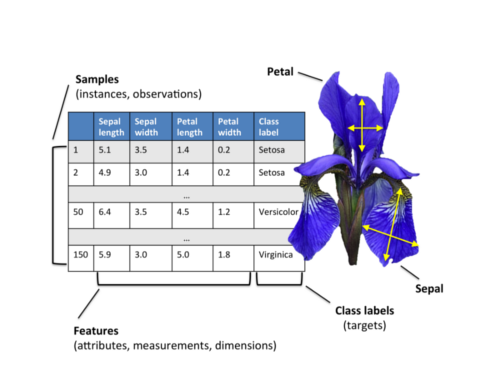|
|:--:|
|**Iris Dataset** |

In [19]:
## Cargamos el dataset de plantas de Iris
iris = load_iris()
iris_X, iris_y = iris.data, iris.target
#Divididmos en entremamiento y prueba
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y,
                                                    test_size=0.30,
                                                    random_state=3,
                                                    stratify=iris_y)

In [20]:
# Instanciamos y entremamos un clasificacor nearest centroids
iris_clf=NearestCentroid(distance='coseno').fit(iris_X_train,iris_y_train)

In [21]:
# Los centroides son en 4 dimensiones
iris_clf.centroids_

{0: array([5.06      , 3.45714286, 1.44      , 0.25142857]),
 1: array([5.95142857, 2.78      , 4.25142857, 1.30571429]),
 2: array([6.58      , 3.00285714, 5.55428571, 2.01714286])}

In [22]:
# Predecimos las etiquetas del conjunto de prueba
iris_yp=iris_clf.predict(iris_X_test)
# Medidas de bondad
print("Recall: ", recall_score(iris_y_test,iris_yp,average='macro'))
print("F1: ", f1_score(iris_y_test,iris_yp,average='macro'))
print("Precision: ", precision_score(iris_y_test,iris_yp,average='macro'))

Recall:  0.9777777777777779
F1:  0.9777530589543938
Precision:  0.9791666666666666


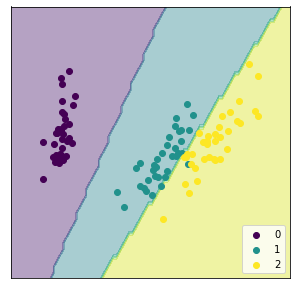

In [23]:
# Limite de decisión proyectado con PCA, recuerde que los elemetos son de dimension 4
plotDecisionBoundary(iris_clf,iris_X_train,iris_y_train)

## Clasificador $k$ Nearest Neighbor

El clasificador $k$ nearest neighbor ($k$NN), es un método no paramétrico que utiliza todos ejemplos en el conjunto de entrenamiento para predecir la clase de los ejemplos no etiquetados. Por lo que no hay fase de entrenamiento, la predicción se realiza mediante el uso de una función de similitud/distancia.

El clasificador $k$NN es simple e intuitivo, para $k=1$ funciona como sigue: dado un vector $x_q$, se le asocia la clase $\theta_q$ que será la misma que tenga el elemento más similar a $x_{nn} \in X$ más similar a $x_q$. El objeto $x_{nn}$ se determina como  $\arg\!\max_{1 \leq i \leq |X|} \cos (x_q, x_i)$ cuando se utiliza la similitud coseno o bien como $\arg\!\min_{1 \leq i \leq |X|} d(u, x_i)$  cuando se utiliza una función de distancia. Lo anterior da el origen al nombre desde que para determinar la clase de un objeto no etiquetado, primero debe encontrarse su vecino más cercano.  Una mejora directa es utilizar más de un vecino para calcular la clase de $x_q$, es decir utilizar $k>1$. Para $k>1$ se puede asignar a $x_q$ la clase que más se repita entre los $k$ vecinos más cercanos de $x_q$ (**pesado uniforme**).

|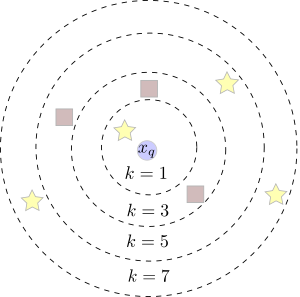|
|:--:|
|**Consulta $k$NN para diferentes valores de $k$**|

### Pesado de vecinos por distancia

También es común realizar un pesado de la contribución de cada vecino basados en el valor de la función de distancia o similitud. Para nuestro caso solo utilizaremos dos variantes simples. 

-  **$k$NN distancia/similitud media**: En este caso se asigna a  $x_q$ la clase en la que la distancia media de los $k$ vecinos seleccionados sea menor. Mientras que se utiliza el valor mayor cuando se utiliza una función de similitud.
- **$k$NN pesado por distancia**: Una forma básica de pesar cuando se utiliza una función de distancia es asignar a cada etiqueta un peso equivalente al inverso de la distancia. En el caso de la similitud puede ser el valor normalizado de la misma(cuando se usa coseno el valor ya está entre 0 y 1). Se asigna la clase que tenga el mayor peso.

Por ejemplo suponga que la información de cinco vecinos más cercanos para un $x_q$ dado en problema de 3 clases se resumen en la siguiente tabla. 

|&nbsp;|$x_1$|$x_2$|$x_3$|$x_4$|$x_5$|
|:------------:|:---:|:---:|:---:|:---:|:---:|
|Clase de $x_i$|  2  |  1  |  2  |  1  |  0  |
|$$d(x_i,x_q)$$| 0.5 | 0.2 |0.25 | 0.4 |0.125|
|$$w_{x_i}$$       |  2  |  5  |  4  | 2.5 |  8  |

en las siguiente tabla se muestra como se calculan los scores para cada clase

| <br /> | distancia media                    | pesado por distancia |uniforme|
|:------:|:---------------------------------: |:--------------:       |:----:|
|Clase 0 |  $d(x_5,x_q)/1$=**0.125**          |$w_{x_0}$=**8**            |   1  |
|Clase 1 |  $$(d(x_2,x_q)+d(x_4,x_q))/2=0.3$$   |$$w_{x_2}+w_{x_4}=7.5$$|   **2**  |
|Clase 2 |  $$(d(x_1,x_q)+d(x_3,x_q))/2=0.225$$ |$$w_{x_1}+w_{x_3}=6$$  |   **2**  |

usando la información en la tabla anterior podemos ver que para $k=5$, si se utiliza el criterio de la distancia mínimo promedio la clase para $x_q$ sería 0, al igual que para el pesado por distancia; mientras que para la decisión por mayoría de votos podría ser la clase 1 o 2. 

**Nota**: Si se utiliza una función de similitud no es necesario calcular el inverso, pero es buena idea normalizar.

- Se proporciona solución  mediante el uso de indices implementados en la librería **faiss**. En este caso la fase de entrenamiento consiste en generar el indice para los datos de entrenamiento.
- La versión **bruta/lineal** de $k$NN,  cada que se predice se debe calcular la distancia con respecto a todos los elementos en el conjunto de entrenamiento para determinar los $k$  más cercano. En este caso la fase de entrenamiento no se realiza, pero la predicción es costosa.


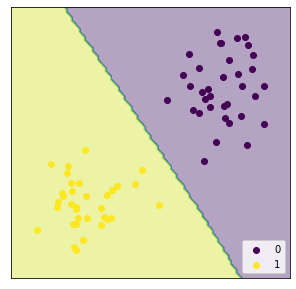

In [24]:
#Probamos el clasificador con pesado uniforme con el ejemplo de los blobs
nn_clf=kNN(k=3,weight_type="uniform").fit(blobs_X_train,blobs_y_train)
plotDecisionBoundary(nn_clf,blobs_X_train,blobs_y_train)

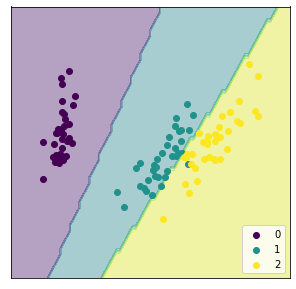

In [25]:
#El data set de Iris
nn_clf=kNN(k=3,weight_type="uniform").fit(iris_X_train,iris_y_train)
plotDecisionBoundary(nn_clf,iris_X_train,iris_y_train)

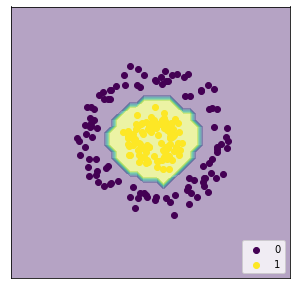

In [26]:
#Dataser de los circulos, utilizando distancia euclidiana
nn_clf=kNN(distance='euclideana', 
           k=3,weight_type="uniform").fit(circles_X_train,circles_y_train)
plotDecisionBoundary(nn_clf,circles_X_train,circles_y_train)

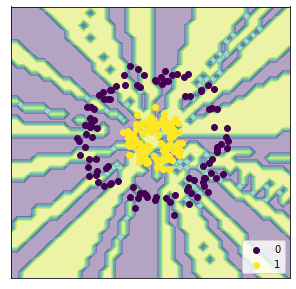

In [27]:
#Dataser de los circulos, utilizando distancia euclidiana
nn_clf=kNN(k=3,distance='coseno',weight_type="uniform").fit(circles_X_train,circles_y_train)
plotDecisionBoundary(nn_clf,circles_X_train,circles_y_train)

## Un problema de texto  (Identificación de humor HAHA -2019)

Para este ejemplo utilizaremos los datos proporcionados para la tarea 1 del HAHA - Humor Analysis based on Human Annotation, la cual consiste determinar si tweets en español son humorísticos o no (un problema de clasificación binaria). Esta tarea forma parte del Iberian Languages Evaluation Forum (IberLEF 2019).

### Corpus 

El conjunto de datos fue etiquetado como se indica [5]. Todos los tweets están etiquetados como humorístico **is_humor=1**  o no humorístico **is_humor=0**. Los datos relevantes para el problema se clasificación ser muestran en el siguiente ejemplo:

|Desscripción|Clave|Valor|
|:------:|:------:|:-----:|
|Tweet |text|Después de la tormenta sale... Tu mamá gritando porque no metiste la ropa.|
|Etiqueta de clase|is_humor|1|
|Representación vectorial|vec| Vectores de dimensión 300 (FastText preentrenados para español) |
|Identificador|id|942079817905770496|



In [28]:
# Cargamos lod datos.
train_data=pd.read_json('data/haha_train_ft_pre_min10.json',lines=True)

ValueError: Expected object or value

In [ ]:
#Vemos los primeros 5
train_data.head()[['id','text','is_humor','vec']]

In [ ]:
#Dimensión de los vectores
len(train_data.vec[3])

In [ ]:
# Los datos de prueba
test_data=pd.read_json('data/haha_test_ft_pre_min10.json',lines=True)

In [ ]:
#Obtenemos la representación vectorial para los conjunto de prueba y entrenamiento
train,y_train=np.array([np.array(x) for x in train_data.vec]),np.array(train_data.is_humor)
test,y_test=np.array([np.array(x) for x in test_data.vec]),np.array(test_data.is_humor)

In [ ]:
#Usamos nuestro clasificacdor NC
haha_clf=NearestCentroid(distance='coseno',centroid_type='Average').fit(train,y_train)

In [ ]:
#Vemos la frontera de decisión
plotDecisionBoundary(haha_clf,train, y_train)

In [ ]:
#Predecimos las etiqueta del conjunto de prueba
haha_yp=haha_clf.predict(test)

In [ ]:
# Medidas de bondad
print("Recall: ", recall_score(y_test,haha_yp,average='macro'))
print("F1: ", f1_score(y_test,haha_yp,average='macro'))
print("Accuracy: ",accuracy_score(y_test,haha_yp))
print("F1 Humor: ", f1_score(y_test,haha_yp))

In [ ]:
#Ahora probamos el clasificador kNN con pesado uniforme
haha_clfk=kNN(distance='coseno',k=5,weight_type='uniform').fit(train,y_train)

In [ ]:
#Predecimos
haha_ypk=haha_clfk.predict(test)

In [ ]:
# Medidas de bondad
print("Recall: ", recall_score(y_test,haha_ypk,average='macro'))
print("F1: ", f1_score(y_test,haha_ypk,average='macro'))
print("Accuracy: ", accuracy_score(y_test,haha_ypk))
print("F1 Humor: ", f1_score(y_test,haha_ypk))

In [ ]:
#Frontera de decisión
plotDecisionBoundary(haha_clfk,train,y_train)

## Actividad

Implementar las diferentes estrategias de generación de centroides para los clasificadores Nearest Centroid así como las formas de pesado para el clasificador de vecinos cercanos. 

- Una vez implementados aplicar todas las versiones de los mismos al dataset HAHA 2019. Se deben reportar el desempeño. En la siguiente tabla se incluyen las métricas de desempeño a reportar para el clasificador incluido con FastText, así como para el Nerarest Centroid Average y $k$NN con pesado uniforme proporcionado en las palantillas.

------

*Tabla de desempeño para distintos clasificadores utilizando los vectores FastText
pre-entrenados para el idioma español*

------
|Clasificador|Accuracy|Macro F1|Macro Recall|F1 is_humor=1|
|:----------:|:------:|:------:|:----------:|:-----------:|
|FastText| 0.80905 | 0.79327|0.78690|0.73614|
|Nearest Centroid (Average)|0.76475 |0.76006|0.77290|0.72650|
|$k$NN (Pesado Uniforme)|0.79252|0.77397|0.76704|0.70922|
|Nearest Centroid (Rocchio)|
|Nearest Centroid (Suma)|
|Nearest Centroid (Suma normalizada)| 
|$k$NN (distancia mínima media)|  
|$k$NN (distancia pesada)| 

------
<br />

En su reporte deberá completar la tabla con los resultados para cada una de las variaciones de los alagoritmos propuestos. 

- Generar los una representación con pesado tfidf para el dataset HAHA 2019, posteriormente aplicar los clasificadores implementados a la representación generada. Incluir los resultados en forma de tabla. Justificar los resultados obtenidos en función de como son con los obtenidos sobre los vectores pre-entrenado


### Entregables
- Un archivo zip que contenga:
    - Reporte en un notebook de jupyter
    - Reporte en versión PDF
    - Archivo .py con la implementación de sus funciones (preprocesamiento, clasificadores, etc)

## Referencias 

1. G. Salton. Automatic Text Processing: The Transformation Analysis and Retrieval of Information by Computer. Addison-Wesley, 1989.
2. W. Cohen and Y. Singer. Context-sensitive learning methods for text categorization. ACM Transactions on Information Systems, 17(2):141–173, 1999
3. D. Ittner, D. Lewis, and D. Ahn. Text categorization of low quality images. In Proceedings of SDAIR-95, 4th Annual Symposium on Document Analysis and Information Retrieval, pages 301–315, 1995.
4. T. Joachims. A probabilistic analysis of the Rocchio algorithm with TFIDF for text categorization. In Proceedings of ICML-97, 14th International Conference on Machine Learning, pages 143–151. Morgan Kaufmann Publishers, 1997.
5. Castro, S., Chiruzzo, L., Rosá, A., Garat, D., & Moncecchi, G. (2018). A crowd-annotated spanish corpus for humor analysis. In Proceedings of the Sixth International Workshop on Natural Language Processing for Social Media (pp. 7-11).
6. Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the Association for Computational Linguistics, 5, 135-146.
7. Tutorial FastText, https://github.com/facebookresearch/fastText/blob/master/docs/supervised-tutorial.md
8. FastText Pre-trained word vector, https://fasttext.cc/docs/en/pretrained-vectors.html
9. Biblioteca faiss, https://github.com/facebookresearch/faiss/wiki/Getting-started

## Uso básico de faiss

In [ ]:
import faiss                   # importar faiss
index = faiss.IndexFlatL2(300)   # construir el indice para vectores de dimension 300 
index.add(train.astype('float32'))  # agregar los elementos al indice
# encontrar los 5 vencinos más cercanos para cada elemento en el test
D,I=index.search(test.astype('float32'), 5) 

In [ ]:
#Los ids de los cinco vecinos más cercanos del elemento 5 del test
print(I[5])

In [ ]:
#Los valores de las distancias de los 5 vecinos más cercanos del elemento 5 del test
print(D[5])

In [ ]:
x=eval('coseno')

In [ ]:
x(D[10],D[0])